# Web Log Anomaly Detection

### Import Modules

In [1]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

### Getting Spark Session

In [ ]:
spark = SparkSession.builder \
                    .master("spark://node-201:7077") \
                    .appName("Web Log Anomaly Detection") \
                    .config("spark.submit.deployMode", "client") \
                    .config("spark.executor.instances", "4") \
                    .config("spark.executor.memory", "8g") \
                    .config("spark.executor.cores", "8") \
                    .enableHiveSupport() \
                    .getOrCreate()

### Getting Spark Context

In [ ]:
sc = spark.sparkContext

### Apache Access Log Parser

In [ ]:
import re
from dateutil import parser
from pyspark.sql import Row

#APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] "(\S+)? ?(\S+)? ?(\S+)?" (\d{3}) ([\d-]+) ?"?([^"]+)?"? ?"?([^"]+)?"?'
APACHE_ACCESS_LOG_PATTERN = '^(\S+) (\S+) (\S+) \[([\w:/]+\s[+\-]\d{4})\] '
pattern = re.compile(APACHE_ACCESS_LOG_PATTERN)

def apache_access_log_parse(line):
    row = None

    try:
        m = pattern.match(line)

        time = m.group(4)
        time = parser.parse(time.replace(':', ' ', 1))

        #date = time.strftime('%Y%m%d')

        #size = m.group(9)
        #if size == '-': size = 0
        #else: size = long(size)

        row = Row(#host     = m.group(1),
                  #identity = m.group(2),
                  #user     = m.group(3),
                  time     = time)
                  #method   = m.group(5),
                  #url      = m.group(6),
                  #protocol = m.group(7),
                  #status   = m.group(8),
                  #size     = size,
                  #referer  = m.group(10),
                  #agent    = m.group(11),
                  #date     = date)
    except:
        print "apache access log parsing error : ", line

    return row

### Loading Data

In [ ]:
LOG_FILE_PATH = 'hdfs://node-201:9000/data/weblog/2015'
rdd = sc.textFile(LOG_FILE_PATH) \
        .map(apache_access_log_parse) \
        .filter(lambda x: x is not None)
df = spark.createDataFrame(rdd)

In [ ]:
df.show(10, False)

### 1. 요청 건수 이상 탐지

#### 데이터 전처리

In [ ]:
request_cnt_df = df.groupby('time').count().sort('time')

#### Pandas 로 변환

In [ ]:
request_cnt_pdf = request_cnt_df.toPandas()
request_cnt_pdf = request_cnt_pdf.set_index('time')

#### 이동 평균 추가

In [7]:
request_cnt_pdf['MA20'] = request_cnt_pdf['count'].rolling(20).mean()
request_cnt_pdf['MS20'] = request_cnt_pdf['count'].rolling(20).std()

#### 체크포인트 생성/로드

In [2]:
request_cnt_pdf = pd.read_pickle('request_cnt_2015.pkl')
#request_cnt_pdf.to_pickle('request_cnt_2015.pkl')

#### 데이터 확인

In [3]:
print request_cnt_pdf.describe()
request_cnt_pdf.tail(10)

              count          MA20          MS20
count  3.486514e+06  3.486495e+06  3.486495e+06
mean   9.125499e+01  9.125528e+01  2.572619e+01
std    1.048811e+02  9.942676e+01  2.261026e+01
min    1.000000e+00  1.000000e+00  0.000000e+00
25%    4.000000e+00  4.100000e+00  2.214783e+00
50%    6.000000e+01  6.490000e+01  2.416016e+01
75%    1.410000e+02  1.430000e+02  3.886495e+01
max    1.212000e+03  7.894000e+02  2.237418e+02


,count,MA20,MS20
time,,,
2015-12-31 05:29:52,94,83.95,29.942884
2015-12-31 05:29:53,44,83.35,30.644438
2015-12-31 05:29:54,91,84.05,30.651651
2015-12-31 05:29:55,74,83.45,30.728822
2015-12-31 05:29:56,85,83.30,30.712761
2015-12-31 05:29:57,70,82.80,30.850403
2015-12-31 05:29:58,91,84.75,30.022579
2015-12-31 05:29:59,97,87.70,28.018979
2015-12-31 05:30:00,47,85.90,29.456301


#### 데이터 시각화

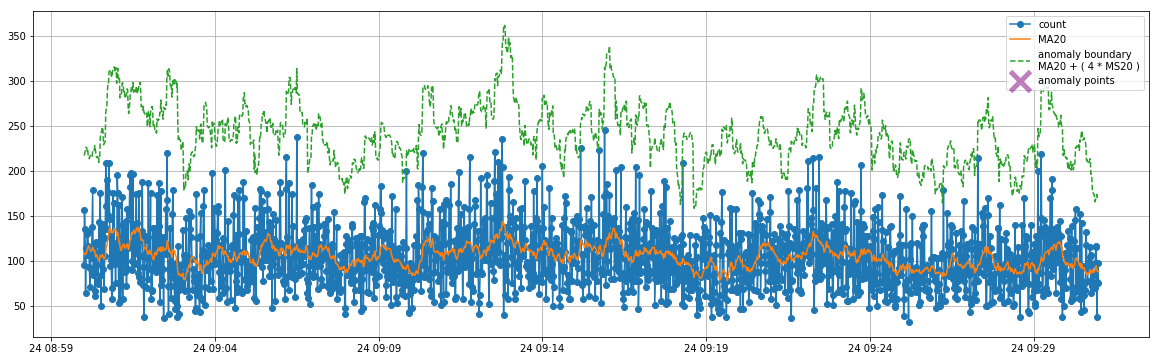

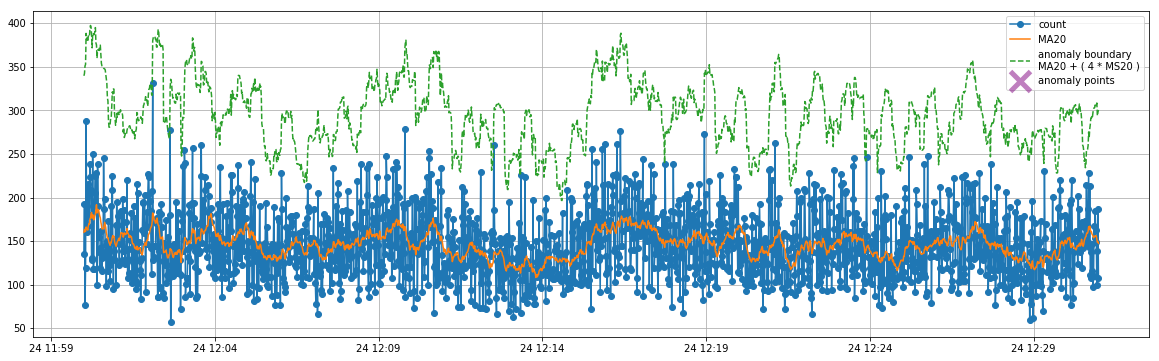

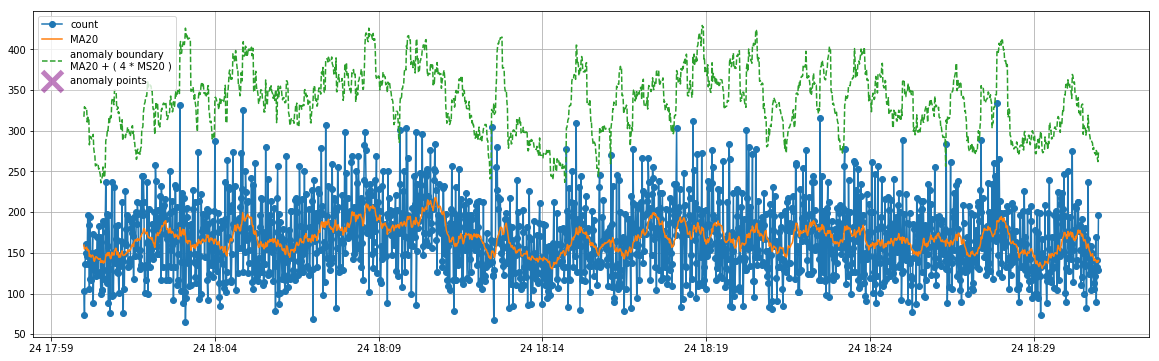

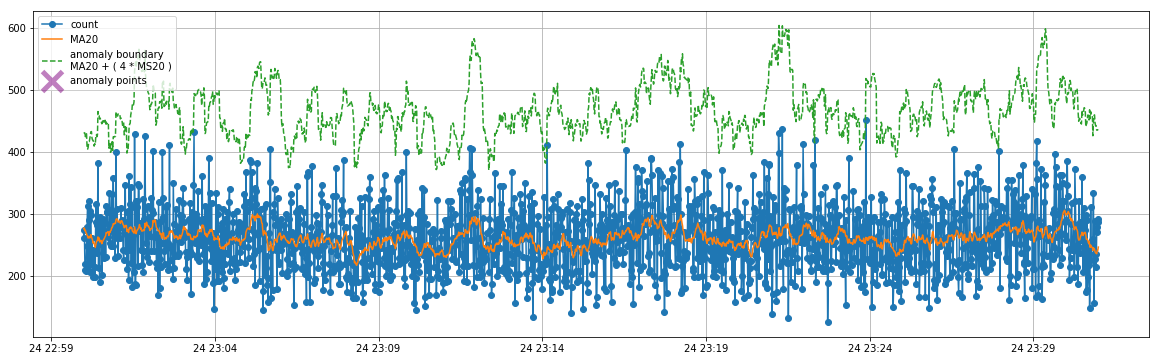

In [4]:
def plot(df):
    plt.figure(figsize=(20,6))
    
    threshold = df['MA20'] + ( 4 * df['MS20'] )
    threshold_label = 'anomaly boundary\nMA20 + ( 4 * MS20 )'
    
    plt.plot(df.index, df['count'], linestyle='solid', marker='o')
    plt.plot(df.index, df['MA20'], linestyle='solid')
    plt.plot(df.index, threshold, linestyle='dashed', label=threshold_label)
    
    anomaly = df[df['count'] > threshold]
    if not anomaly.empty: print "[anomaly points]\n", anomaly
    plt.plot(anomaly.index, anomaly['count'], 's',label='anomaly points', color='purple', linewidth=8, 
             marker='x', markeredgecolor='purple', markeredgewidth=5, markersize=20, alpha=0.5)
    
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()
    
plot(request_cnt_pdf['2015-12-24 09:00':'2015-12-24 09:30'])
plot(request_cnt_pdf['2015-12-24 12:00':'2015-12-24 12:30'])
plot(request_cnt_pdf['2015-12-24 18:00':'2015-12-24 18:30'])
plot(request_cnt_pdf['2015-12-24 23:00':'2015-12-24 23:30'])


#### 시나리오 적용
 1. 서비스 거부 공격 : 요청 건수가 급격하게 늘어나는 상황.
 2. 시스템 장애 : 요청 건수가 급격하게 줄어드는 상황.

In [5]:
# TODO

# 1. 서비스 거부 공격
#np.random.random_sample()
#np.linspace(0, 2*np.pi, 10)
#cnt = request_cnt_pdf['2015-12-18 21:46:00':'2015-12-18 21:49:00'].count()
request_cnt_pdf['2015-12-18 21:47:00':'2015-12-18 21:48:00']['count'] = request_cnt_pdf['2015-12-18 21:47:00':'2015-12-18 21:48:00']['count'] * 5
#for i in range(cnt):
#    r = np.random.random_sample()
#    request_cnt_pdf['count']['2015-12-18 21:46:00'] = 3000 * r
    
# 2. 시스템 장애


/home/hadoop-standalone/apps/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


[anomaly points]
                     count   MA20       MS20
time                                        
2015-12-18 21:47:00   2560  666.6  457.91615


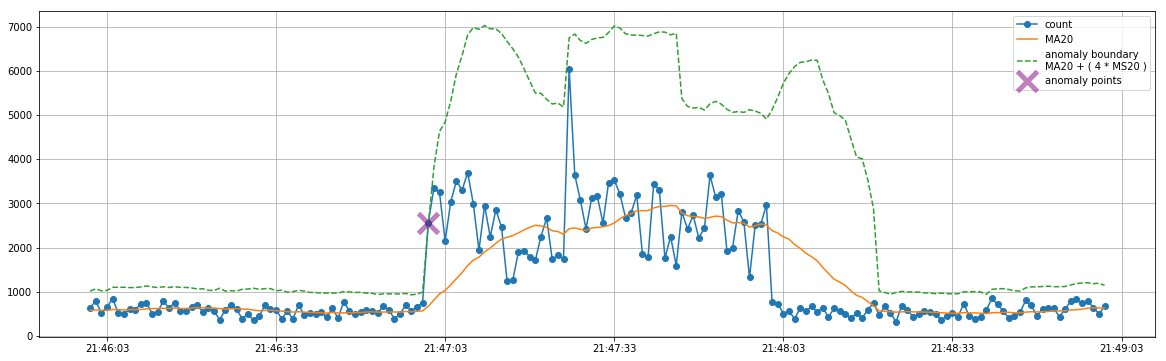

In [11]:
#request_cnt_pdf.sort_values(['count'], ascending=[False])[:10]
#plot(request_cnt_pdf[970:1100])
plot(request_cnt_pdf['2015-12-18 21:46:00':'2015-12-18 21:49:00'])

####  이상 탐지

In [10]:
# 정렬
anomaly = request_cnt_pdf[request_cnt_pdf['count'] > request_cnt_pdf['MA20']+(4*request_cnt_pdf['MS20'])]
anomaly.sort_values(['count'], ascending=[False])#[:10]
# 4.24852925

# 첫번째 이상 데이터 시각화
#plot(request_cnt_pdf['2015-10-24 22:40:10':'2015-10-24 22:40:40'])
#plot(request_cnt_pdf['2015-11-04 13:51:00':'2015-11-04 13:51:20'])
#plot(request_cnt_pdf['2015-10-24 10:45:20':'2015-10-24 10:47:30'])

# TODO : 값이 0인 경우도 고려

,count,MA20,MS20
time,,,
2015-12-18 21:47:00,2560,666.60,457.916150
2015-10-24 22:40:32,240,15.20,53.773012
2015-10-24 15:08:59,180,13.35,41.501141
2015-12-04 20:13:39,148,32.60,28.566451
2015-12-09 04:57:57,106,20.70,21.069059
2015-12-05 03:55:27,106,21.00,20.637217
2015-12-05 03:52:52,104,20.10,20.338970
2015-11-06 11:19:44,102,10.20,21.676084
2015-12-05 03:39:08,100,24.70,18.390787


#### 평가

In [ ]:
# TODO
'''
from sklearn import metrics
metrics.classification_report(y_true, y_pred)
metrics.confusion_matrix(y_true, y_pred[, …])
roc auc
'''

#### 최적화
 - 시간축 해상도
 - 이동 평균 윈도우 크기
 - 이동 표준편차 윈도우 크기
 - anomaly boundary

이상 시작점 뿐만 아니라 진행중인 구간에서도 탐지할 수 있도록.

### 2. 클라이언트 수 이상 탐지

In [ ]:
# TODO

### 3. 응답 크기 이상 탐지

In [ ]:
# TODO